#  在MNIST数据集上训练一个生成对抗网络


在本教程中，我们将在 MNIST 数据集上训练一个生成对抗网络（GAN）。这是一个手写数字的28x28像素图像的大集合。我们将尝试训练一个网络来生成新的手写数字图像。


## Colab

This tutorial and the rest in this sequence are designed to be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/Training_a_Generative_Adversarial_Network_on_MNIST.ipynb)



In [ ]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

首先，让我们导入所有需要的库并加载数据集（它与 Tensorflow 捆绑在一起）。

In [1]:
import deepchem as dc
import tensorflow as tf
from deepchem.models.optimizers import ExponentialDecay
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Reshape
import matplotlib.pyplot as plot
import matplotlib.gridspec as gridspec
%matplotlib inline

mnist = tf.keras.datasets.mnist.load_data(path='mnist.npz')
images = mnist[0][0].reshape((-1, 28, 28, 1))/255
dataset = dc.data.NumpyDataset(images)

让我们来看看其中的一些图片，了解一下它们的样子。

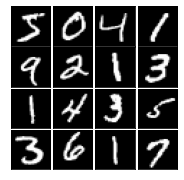

In [2]:
def plot_digits(im):
  plot.figure(figsize=(3, 3))
  grid = gridspec.GridSpec(4, 4, wspace=0.05, hspace=0.05)
  for i, g in enumerate(grid):
    ax = plot.subplot(g)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(im[i,:,:,0], cmap='gray')

plot_digits(images)

现在我们可以创建 GAN 了。和上一篇教程一样，它由两部分组成:

1. 生成器会把随机噪声作为输入，并试图产生与训练数据相似的输出。
2. 判别器接受一组样本作为输入（可能是训练数据，可能是生成器创建的），并试图确定哪些是哪些。

这次我们将使用一种不同风格的 GAN，称为 Wasserstein GAN （或简称WGAN）。在许多情况下，它们被发现比传统的 GANs 产生更好的结果。两者之间的主要区别在于判别器（在这种情况下通常称为“批评家”）。它试图学习如何测量训练数据集分布和生成数据集分布之间的距离，而不是输出样本作为真实训练数据的概率。然后，该测量方法可以直接用来作为训练生成器的损失函数。

我们使用一个非常简单的模型。该生成器使用一个密集层将噪声输入转换为一个具有8通道的7x7图像。接下来是两个卷积层，首先升采样到14x14，最后升采样到28x28。

判别器反向执行大致相同的操作。两个卷积层降采样图像，首先到14x14，然后到7x7。最后一个密集层产生一个数字作为输出。在上一篇教程中，我们使用了 sigmoid 激活来生成一个0到1之间的数字，它可以被解释为概率。由于这是一个 WGAN ，因此我们使用 [softplus](https://blog.csdn.net/hy592070616/article/details/120623303) 激活函数。它产生一个无界正数，可以解释为一个距离。

In [3]:
class DigitGAN(dc.models.WGAN):

  def get_noise_input_shape(self):
    return (10,)

  def get_data_input_shapes(self):
    return [(28, 28, 1)]

  def create_generator(self):
    return tf.keras.Sequential([
        Dense(7*7*8, activation=tf.nn.relu),
        Reshape((7, 7, 8)),
        Conv2DTranspose(filters=16, kernel_size=5, strides=2, activation=tf.nn.relu, padding='same'),
        Conv2DTranspose(filters=1, kernel_size=5, strides=2, activation=tf.sigmoid, padding='same')
    ])

  def create_discriminator(self):
    return tf.keras.Sequential([
        Conv2D(filters=32, kernel_size=5, strides=2, activation=tf.nn.leaky_relu, padding='same'),
        Conv2D(filters=64, kernel_size=5, strides=2, activation=tf.nn.leaky_relu, padding='same'),
        Dense(1, activation=tf.math.softplus)
    ])

gan = DigitGAN(learning_rate=ExponentialDecay(0.001, 0.9, 5000))

现在训练它。和上一篇教程一样，我们编写了一个数据生成器来生成数据。这次的数据来自一个数据集，我们将循环100次。

还有一个区别值得注意。在训练传统 GAN 时，重要的是在整个训练过程中保持生成器和判别器的平衡。如果其中一个走得太远，另一个就很难学习了。

WGANs 没有这个问题。事实上，判别器变得越好，它提供的信号就越清晰，生成器就越容易学习它。因此，我们指定 `generator_steps=0.2` ，以便每训练判别器5步，只需要训练生成器1步。这往往产生更快的训练效果和更好的结果。

In [4]:
def iterbatches(epochs):
  for i in range(epochs):
    for batch in dataset.iterbatches(batch_size=gan.batch_size):
      yield {gan.data_inputs[0]: batch[0]}

gan.fit_gan(iterbatches(100), generator_steps=0.2, checkpoint_interval=5000)

Ending global_step 4999: generator average loss 0.340072, discriminator average loss -0.0234236
Ending global_step 9999: generator average loss 0.52308, discriminator average loss -0.00702729
Ending global_step 14999: generator average loss 0.572661, discriminator average loss -0.00635684
Ending global_step 19999: generator average loss 0.560454, discriminator average loss -0.00534357
Ending global_step 24999: generator average loss 0.556055, discriminator average loss -0.00620613
Ending global_step 29999: generator average loss 0.541958, discriminator average loss -0.00734233
Ending global_step 34999: generator average loss 0.540904, discriminator average loss -0.00736641
Ending global_step 39999: generator average loss 0.524298, discriminator average loss -0.00650514
Ending global_step 44999: generator average loss 0.503931, discriminator average loss -0.00563732
Ending global_step 49999: generator average loss 0.528964, discriminator average loss -0.00590612
Ending global_step 54999

让我们生成一些数据，看看结果如何。

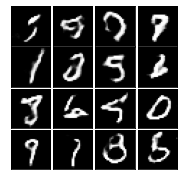

In [5]:
plot_digits(gan.predict_gan_generator(batch_size=16))

还不错。许多生成的图像看起来很像手写的数字。当然，经过较长时间训练的较大模型可以做得更好。

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!